# Rudder Kick

Simulate a pilot performing a rudder kick test by inputing a rudder input based
on a ramp input. Aileron input is also included to maintain a steady heading 
sideslip (SHSS). The time histories of the control inputs and beta (sideslip angle)
are plotted.

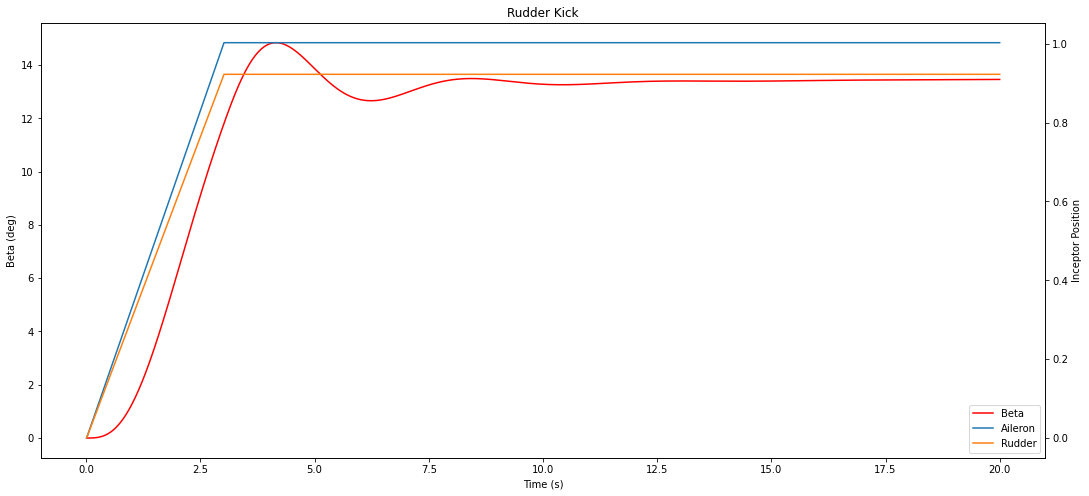

In [1]:
import jsbsim
import matplotlib.pyplot as plt
import math

# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="737"
# Path to JSBSim files, location of the folders "aircraft", "engines" and "systems"
PATH_TO_JSBSIM_FILES="../.."

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

# Load the aircraft model
fdm.load_model(AIRCRAFT_NAME)

# Set engines running
fdm['propulsion/set-running'] = -1

# Set alpha range for trim solutions
fdm['aero/alpha-max-rad'] = math.radians(12)
fdm['aero/alpha-min-rad'] = math.radians(-4.0)

dt = fdm.get_delta_t()

# Max control deflection
aileronMax = 1
rudderMax = 0.92

# Number of seconds for control surface to reach max deflection
risetime = 3

# Per timestep increment for control surfaces
diAileron = aileronMax / (risetime/dt)
diRudder = rudderMax / (risetime/dt)

# Recorded data
times = []

betas = []
bankAngle = []
ailerons = []
rudder = []

# Initial conditions
fdm['ic/h-sl-ft'] = 1000
fdm['ic/vc-kts'] = 200
fdm['ic/gamma-deg'] = 0
fdm['ic/beta-deg'] = 0

# Initialize the aircraft with initial conditions
fdm.run_ic() 

# Trim
try:
    fdm['simulation/do_simple_trim'] = 1

except jsbsim.TrimFailureError:
    print("Trim failed, continuing rudder kick in an untrimmed state.")
    pass  # Ignore trim failure

# Time to run for in seconds
run_period = 20

for i in range(int(run_period/dt)):
    fdm.run()

    times.append(fdm.get_sim_time())

    betas.append(fdm['aero/beta-deg'])
    bankAngle.append(fdm['attitude/phi-deg'])
    ailerons.append(fdm['fcs/aileron-cmd-norm'])
    rudder.append(fdm['fcs/rudder-cmd-norm'])

    aileronCmd = fdm['fcs/aileron-cmd-norm']
    rudderCmd = fdm['fcs/rudder-cmd-norm']

    if aileronCmd < aileronMax:
        aileronCmd += diAileron
        fdm['fcs/aileron-cmd-norm'] = aileronCmd

    if rudderCmd < rudderMax:
        rudderCmd += diRudder
        fdm['fcs/rudder-cmd-norm'] = rudderCmd

# Plot results
plt.rcParams["figure.figsize"] = (18, 8)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Beta (deg)')
line1 = ax1.plot(times, betas, label='Beta', color='red')

ax2 = ax1.twinx()

ax2.set_ylabel('Inceptor Position')
line2 = ax2.plot(times, ailerons, label='Aileron')
line3 = ax2.plot(times, rudder, label='Rudder')

ax1.legend(handles=line1+line2+line3, loc=4)

plt.title('Rudder Kick')

plt.show()